In [3]:
import simpy
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

Average waiting time for M/M/1: 836.776
95% Confidence Interval: (827.282, 846.270)
Average waiting time for M/M/2: 569.388
95% Confidence Interval: (564.804, 573.973)
Average waiting time for M/M/4: 331.537
95% Confidence Interval: (329.653, 333.421)
Number of servers = 1
For ρ = 0.1, measurements required: 1006
For ρ = 0.108989898989899, measurements required: 873
For ρ = 0.11797979797979799, measurements required: 871
For ρ = 0.12696969696969698, measurements required: 751
For ρ = 0.13595959595959597, measurements required: 713
For ρ = 0.14494949494949497, measurements required: 697
For ρ = 0.15393939393939393, measurements required: 647
For ρ = 0.16292929292929292, measurements required: 639
For ρ = 0.17191919191919192, measurements required: 574
For ρ = 0.1809090909090909, measurements required: 577
For ρ = 0.1898989898989899, measurements required: 1021
For ρ = 0.1988888888888889, measurements required: 513
For ρ = 0.20787878787878789, measurements required: 926
For ρ = 0.2168686

<function matplotlib.pyplot.show(close=None, block=None)>

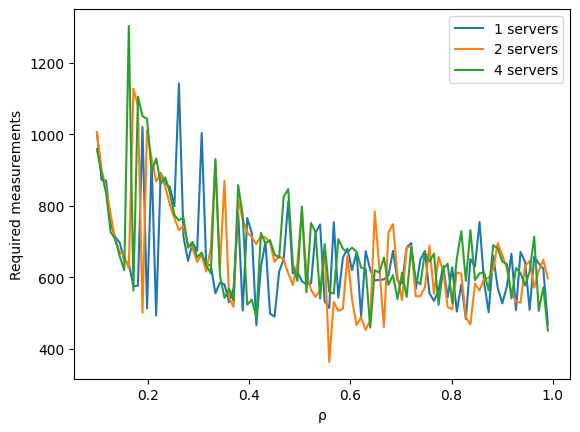

In [13]:
def queue_function(env, mu, waiting_times, queue): # Simulation for one single job
    
    while True:

        arrival_time = env.now # Register time at which job arrives
        
        with queue.request() as request:
            yield request # Join the queue
            waiting_times.append(env.now - arrival_time) # Calculate waiting time

            service_time = np.random.exponential(1 / mu) # Draw a random time from an exponential distribution with mean 1/mu ()
            yield env.timeout(service_time) # Add service time

def arrivals(env, lambda_, queue, mu, waiting_times): # Continuously create new jobs
    while True:
        yield env.timeout(np.random.exponential(1 / lambda_)) # Pause time until next arrival (randomly drawn from exponential distribution)
        env.process(queue_function(env, mu, waiting_times, queue)) # Start new process for new job

def simulation(lambda_, mu, servers, jobs):

    env = simpy.Environment() # Create general environment
    queue = simpy.Resource(env, capacity = servers) # Set number of servers
    waiting_times = []

    env.process(arrivals(env, lambda_, queue, mu, waiting_times)) # Start creating continuously new jobs

    env.run(until = jobs / lambda_) # Run simulation for expected time needed to get the number of jobs desired

    # Compute average waiting time and corresponding 95% confidence interval
    mean_waiting_time = np.mean(waiting_times)
    measurements = len(waiting_times)
    std_dev_waiting_time = np.std(waiting_times, ddof = 1)
    n = len(waiting_times)
    bound = z * (std_dev_waiting_time / np.sqrt(n))
    ci_low = mean_waiting_time - bound
    ci_high = mean_waiting_time + bound

    return mean_waiting_time, measurements, std_dev_waiting_time, (ci_low, ci_high)

# Set parameters
lambda_ = 2.95 # Arrival rate
mu = 3 # Servers capacity
jobs = 10000 # Number of jobs to be completed
z = norm.ppf(0.975) # Z for confidence interval

# Run simulation for 1, 2 and 4 servers
for servers in [1, 2, 4]:
    avg_waiting_time, measurements, std, confidence_interval = simulation(lambda_, mu, servers, jobs)
    print(f'Average waiting time for M/M/{servers}: {avg_waiting_time:.3f}')
    print(f'95% Confidence Interval: ({confidence_interval[0]:.3f}, {confidence_interval[1]:.3f})')

def measurements_required(target_error, rhos, mu, servers): # Calculate the number of jobs the system has to go through to reach the error desired in the estimation of the mean time

    results = []

    for rho in rhos: # Make the measurement dependent on a set of rho's

        lambda_ = rho * servers * mu # Derive Lambda
        error = float('inf') # To initiate the while loop
        jobs = 100

        while error > target_error: # Keep simulating as long as the compited error is larger than the desired one, increasing the number of jobs the system has to go through
            mean, measurements, std, ci = simulation(lambda_, mu, servers, jobs) 
            error = (z * (std / np.sqrt(measurements))) / mean # Calculate the current bound in the confidence interval
            jobs += 100
        
        results.append((rho, measurements))

    return results

rhos = np.linspace(0.1, 0.99, 100)

# Compute and plot the required number of measurements needed for different rho's and numbers of servers
for servers in [1, 2, 4]:
    print(f'Number of servers = {servers}')
    required_jobs = measurements_required(target_error = 0.05, rhos = rhos, mu = mu, servers = servers)
    jobs_list = []
    for rho, jobs in required_jobs:
        print(f'For ρ = {rho}, measurements required: {jobs}')
        jobs_list.append(jobs)
    plt.plot(rhos, jobs_list, label = f'{servers} servers')

plt.xlabel('ρ')
plt.ylabel('Required measurements')
plt.legend()
plt.show


In [20]:
def queue_function_SJF(env, mu, waiting_times, queue): # Simulation for one single job
    
    while True:

        arrival_time = env.now # Register time at which job arrives
        service_time = np.random.exponential(1 / mu) # Draw a random time from an exponential distribution with mean 1/mu ()

        with queue.request(priority = service_time) as request:
            yield request # Join the queue
            waiting_times.append(env.now - arrival_time) # Calculate waiting time
            yield env.timeout(service_time) # Add service time

def arrivals(env, lambda_, queue, mu, waiting_times): # Continuously create new jobs
    while True:
        yield env.timeout(np.random.exponential(1 / lambda_)) # Pause time until next arrival (randomly drawn from exponential distribution)
        env.process(queue_function_SJF(env, mu, waiting_times, queue)) # Start new process for new job

def simulation_SFJ(_SJFlambda_, mu, servers, jobs):

    env = simpy.Environment() # Create general environment
    queue = simpy.PriorityResource(env, capacity = servers) # Set number of servers
    waiting_times = []

    env.process(arrivals(env, lambda_, queue, mu, waiting_times)) # Start creating continuously new jobs

    env.run(until = jobs / lambda_) # Run simulation for expected time needed to get the number of jobs desired

    # Compute average waiting time and corresponding 95% confidence interval
    mean_waiting_time = np.mean(waiting_times)
    measurements = len(waiting_times)
    std_dev_waiting_time = np.std(waiting_times, ddof = 1)
    n = len(waiting_times)
    bound = z * (std_dev_waiting_time / np.sqrt(n))
    ci_low = mean_waiting_time - bound
    ci_high = mean_waiting_time + bound

    return mean_waiting_time, measurements, std_dev_waiting_time, (ci_low, ci_high)

# Set parameters
lambda_ = 2.95 # Arrival rate
mu = 3 # Servers capacity
jobs = 10000 # Number of jobs to be completed
z = norm.ppf(0.975) # Z for confidence interval
servers = 1
# Run simulation for 1, 2 and 4 servers
avg_waiting_time, measurements, std, confidence_interval = simulation_SFJ(lambda_, mu, servers, jobs)
print(f'Average waiting time for M/M/{servers}: {avg_waiting_time:.3f}')
print(f'95% Confidence Interval: ({confidence_interval[0]:.3f}, {confidence_interval[1]:.3f})')

def measurements_required_SFJ(target_error, rhos, mu, servers): # Calculate the number of jobs the system has to go through to reach the error desired in the estimation of the mean time

    results = []

    for rho in rhos: # Make the measurement dependent on a set of rho's

        lambda_ = rho * servers * mu # Derive Lambda
        error = float('inf') # To initiate the while loop
        jobs = 100

        while error > target_error: # Keep simulating as long as the compited error is larger than the desired one, increasing the number of jobs the system has to go through
            mean, measurements, std, ci = simulation_SFJ(lambda_, mu, servers, jobs) 
            error = (z * (std / np.sqrt(measurements))) / mean # Calculate the current bound in the confidence interval
            jobs += 100
        
        results.append((rho, measurements))

    return results

rhos = np.linspace(0.1, 0.99, 100)
required_jobs = measurements_required(target_error = 0.05, rhos = rhos, mu = mu, servers = servers)
jobs_list = []
for rho, jobs in required_jobs:
    print(f'For ρ = {rho}, measurements required: {jobs}')
    jobs_list.append(jobs)
plt.plot(rhos, jobs_list, label = f'{servers} servers')

plt.xlabel('ρ')
plt.ylabel('Required measurements')
plt.legend()
plt.show


Average waiting time for M/M/1: 3.344
95% Confidence Interval: (2.984, 3.704)


TypeError: Put.__init__() got an unexpected keyword argument 'priority'